# Gaussian process

Definition
- A Gaussian process (GP) is a collection of random variables, any finite number of which have a joint Gaussian distribution

[Rasmussen and Williams, 2006].


$y_i = ax_i + b$ : parametic approach example

Gaussian process is non-parametric; $y_i = f(x_i) + \sigma$ (Non-parametric means that the number of parameters is infinite; does not mean non-existent)

## Simplified GP example from scratch

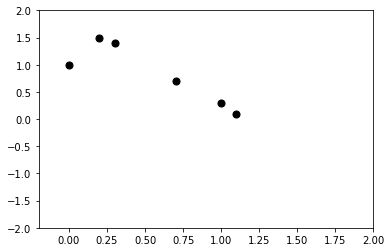

In [20]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF


X = np.array([0, 0.2, 0.3, 0.7, 1, 1.1])
Y = np.array([1, 1.5, 1.4, 0.7, 0.3, 0.1])


plt.figure()
plt.scatter(X,Y, c='k', s=50)
plt.xlim([-0.2,2])
plt.ylim([-2,2])
plt.show()


    


In [21]:
def sqexp(x, x_, l): #squared exponential kernel
    return np.exp(-(np.linalg.norm(x-x_)**2)/(2*l**2))

def covariances(kernel, data1, data2, l):
    cov_mat = np.zeros((len(data1), len(data2)))
    for row_ in range(len(data1)):
        for col_ in range(len(data2)):
            cov_mat[row_,col_] = kernel(data1[row_], data2[col_], l)
    return cov_mat

l = 0.2

cov_mat = covariances(sqexp, X, X, l)

x_star = np.array([1.2, 1.7]) # want to know the value at x=1.2 and 1.7
cov_mat_star = covariances(sqexp, X, x_star, l) 
cov_mat_double_star = covariances(sqexp, x_star, x_star, l)

posterior_mean = cov_mat_star.T @ np.linalg.inv(cov_mat) @ Y #assumed prior is zero mean
# posterior_mean = mean_func - cov_mat_star.T @ np.linalg.inv(cov_mat) @ (Y - mean_func)
posterior_cov = cov_mat_double_star - cov_mat_star.T @ np.linalg.inv(cov_mat) @ cov_mat_star

print("Results from scratch:\n",posterior_mean, "\n", posterior_cov)

Results from scratch:
 [-0.03398249 -0.0033738 ] 
 [[0.07753185 0.02757361]
 [0.02757361 0.99957283]]


In [17]:

kernel = RBF(length_scale=l, length_scale_bounds="fixed")
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X.reshape(-1,1), Y.reshape(-1,1))
print("Results via the library function:\n", gpr.predict(x_star.reshape(-1,1), return_cov=True))

Results via the library function:
 (array([[-0.03398249],
       [-0.0033738 ]]), array([[0.07753185, 0.02757361],
       [0.02757361, 0.99957283]]))


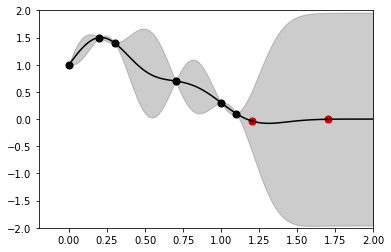

In [18]:
x_r = np.linspace(0,2,100)
mu, sigma = gpr.predict(x_r[:, np.newaxis], return_std=True)
mu = mu.reshape(-1)
plt.figure()
plt.scatter(X, Y, c='k', s=50)
plt.scatter(x_star, posterior_mean, c='r', s=50)
plt.plot(x_r, mu,'k')
plt.fill_between(x_r.ravel(), mu - 1.96*sigma, mu + 1.96*sigma, alpha=0.2, color='k') #95% confidence interval
plt.xlim([-0.2,2])
plt.ylim([-2,2])
plt.show()



Consider a Gaussian process $z(x) = \mathcal{GP}\left(\mu(x),C(x,x';\theta)\right)$
- mean function:
$$\mu(\mathbf{x})=\mathbb{E}\left(z(\mathbf{x})\right)$$
- covariance function
$$C(x,x';\theta)=\mathbb{E}\left[(z(x)-\mu(x))(z(x')-\mu(x'))\right]$$

  - Stationary if $C(x,x';\theta)=C_s(x-x';\theta)$
  - Isotropic if $C(x,x';\theta)=C_s(\|x-x'\|;\theta)$
  
    where a one-parameter covariance function is defined by $C_s(h)=C(0,h)=C(x,x+h)$, and $\theta$ is a hyperparameter vector.

## Gaussian process regression

Denote that $z_* :=z(x_*)$, where $x_∗$ is a point of interest.

Given a data set $\mathcal{D}=\{(x^{(i)},y^{(i)})\mid i = 1,\cdots,n\}$ obtained by
$$
y^{(i)} =z(x^{(i)})+\epsilon^{(i)} , \ \epsilon^{(i)}\overset{i.i.d.}{\sim}\mathcal{N}(0,\sigma^2_w),
$$
and for a given hyperparameter vector $\theta$, the predictive distribution of $z_*:=z(x_*)$ is
$$
z_*\mid\theta,y\sim\mathcal{N}(\mu_{z_*|\theta,y},\theta^2_{za_*|\theta,y})
$$

- predictive mean (prediction):
$$
\mu_{z_*\mid\theta,y}=\mu(x_*)+k^T\underbrace{(K+\sigma_w^2I)^{-1}}_{C_y^{-1}}(y-\mu)
$$
- predictive variance (prediction error variance):
$$
\sigma^2_{z_*\mid\theta,y}=\underbrace{C(x_*,x_*;\theta)}_{\sigma_f^2}+k^T(K+\sigma_w^2I)^{-1}k
$$

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

def plotGP(X=None, y=None, Xstar=None, mu=None, f=None, flabel=None, sigma=None):
    NoneType = type(None)
    plt.figure(figsize=(8,6))
    if type(f) != NoneType and type(Xstar) != NoneType:
        plt.plot(Xstar, f(Xstar), 'r:', label=flabel)
    if type(X) != NoneType and type(y) != NoneType:
        plt.scatter(X, y, c='r', s=50, zorder=10, edgecolors='k', label=u'Observations')
#         plt.plot(X, y, 'r.', markersize=10, label=u'Observations')
    if type(Xstar) != NoneType and type(mu) != NoneType:
        plt.plot(Xstar, mu, 'b-', label=u'Prediction')
    if type(sigma) != NoneType:
#         plt.fill(np.concatenate([Xstar, Xstar[::-1]]),
#                  np.concatenate([mu - 1.96 * sigma,
#                                 (mu + 1.96 * sigma)[::-1]]),
#                  alpha=.2, fc='b', ec='None', label='95% confidence interval')
        plt.fill_between(Xstar.ravel(), mu - 1.96*sigma, mu + 1.96*sigma, alpha=0.2, color='b', label='95% confidence interval')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.legend(loc='upper left')
    plt.show()

def prior_and_posterior(kernel):
    gp = GaussianProcessRegressor(kernel=kernel)
    plt.figure(figsize=(8, 8))
    
    # Plot prior
    plt.subplot(2, 1, 1)
    Xstar = np.linspace(0, 5, 100)
    mu, sigma = gp.predict(Xstar[:, np.newaxis], return_std=True)
    plt.plot(Xstar, mu, 'k', lw=3, zorder=9)
    plt.fill_between(Xstar, mu - sigma, mu + sigma, alpha=0.2, color='k')
    y_samples = gp.sample_y(Xstar[:, np.newaxis], 10)
    plt.plot(Xstar, y_samples, lw=1)
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)

    # Generate data and fit GP
    rng = np.random.RandomState(4)
    X = rng.uniform(0, 5, 10)[:, np.newaxis]
    y = np.sin((X[:, 0] - 2.5) ** 2)
    gp.fit(X, y)

    # Plot posterior
    plt.subplot(2, 1, 2)
    mu, sigma = gp.predict(Xstar[:, np.newaxis], return_std=True)
    plt.plot(Xstar, mu, 'k', lw=3, zorder=9)
    plt.fill_between(Xstar, mu - sigma, mu + sigma, alpha=0.2, color='k')

    y_samples = gp.sample_y(Xstar[:, np.newaxis], 10)
    plt.plot(Xstar, y_samples, lw=1)
    plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
              % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
              fontsize=12)
    plt.show()

## Kernels for Gaussian Processes

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel, WhiteKernel
)

### GP kernel API

The main usage of a Kernel is to compute the GP’s covariance between datapoints. For this, the method ```__call__``` of the kernel can be called. This method can either be used to compute the “auto-covariance” of all pairs of datapoints in a 2d array X, or the “cross-covariance” of all combinations of datapoints of a 2d array X with datapoints in a 2d array Y. The following identity holds true for all kernels k (except for the WhiteKernel): ```k(X) == K(X, Y=X)```

If only the diagonal of the auto-covariance is being used, the method ```diag()``` of a kernel can be called, which is more computationally efficient than the equivalent call to ```__call__```: ```np.diag(k(X, X)) == k.diag(X)```

Kernels are parameterized by a vector $\theta$ of hyperparameters. These hyperparameters can for instance control length-scales or periodicity of a kernel (see below). All kernels support computing analytic gradients of the kernel’s auto-covariance with respect to $\theta$ via setting ```eval_gradient=True``` in the ```__call__``` method. This gradient is used by the Gaussian process (both regressor and classifier) in computing the gradient of the log-marginal-likelihood, which in turn is used to determine the value of $\theta$, which maximizes the log-marginal-likelihood, via gradient ascent. For each hyperparameter, the initial value and the bounds need to be specified when creating an instance of the kernel. The current value of $\theta$ can be get and set via the property ```theta``` of the kernel object. Moreover, the bounds of the hyperparameters can be accessed by the property ```bounds``` of the kernel. Note that both properties (theta and bounds) return log-transformed values of the internally used values since those are typically more amenable to gradient-based optimization. The specification of each hyperparameter is stored in the form of an instance of Hyperparameter in the respective kernel. Note that a kernel using a hyperparameter with name “x” must have the attributes self.x and self.x_bounds.

The abstract base class for all kernels is Kernel. Kernel implements a similar interface as Estimator, providing the methods ```get_params()```, ```set_params()```, and ```clone()```. This allows setting kernel values also via meta-estimators such as Pipeline or GridSearch. Note that due to the nested structure of kernels (by applying kernel operators, see below), the names of kernel parameters might become relatively complicated. In general, for a binary kernel operator, parameters of the left operand are prefixed with ```k1__``` and parameters of the right operand with ```k2__```. An additional convenience method is ```clone_with_theta(theta)```, which returns a cloned version of the kernel but with the hyperparameters set to ```theta```. An illustrative example:

In [6]:
kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0)) * RBF(length_scale=0.5, length_scale_bounds=(0.0, 10.0)) + RBF(length_scale=2.0, length_scale_bounds=(0.0, 10.0))
print('kernel.hyperparameters =')
for hyperparameter in kernel.hyperparameters: print(hyperparameter)
print('\nkernel.get_params() =')
params = kernel.get_params()
for key in sorted(params): print("%s : %s" % (key, params[key]))
print('\nkernel.theta =\n', kernel.theta)  # Note: log-transformed
print('\nkernel.bounds =\n', kernel.bounds)  # Note: log-transformed

kernel.hyperparameters =
Hyperparameter(name='k1__k1__constant_value', value_type='numeric', bounds=array([[ 0., 10.]]), n_elements=1, fixed=False)
Hyperparameter(name='k1__k2__length_scale', value_type='numeric', bounds=array([[ 0., 10.]]), n_elements=1, fixed=False)
Hyperparameter(name='k2__length_scale', value_type='numeric', bounds=array([[ 0., 10.]]), n_elements=1, fixed=False)

kernel.get_params() =
k1 : 1**2 * RBF(length_scale=0.5)
k1__k1 : 1**2
k1__k1__constant_value : 1.0
k1__k1__constant_value_bounds : (0.0, 10.0)
k1__k2 : RBF(length_scale=0.5)
k1__k2__length_scale : 0.5
k1__k2__length_scale_bounds : (0.0, 10.0)
k2 : RBF(length_scale=2)
k2__length_scale : 2.0
k2__length_scale_bounds : (0.0, 10.0)

kernel.theta =
 [ 0.         -0.69314718  0.69314718]

kernel.bounds =
 [[      -inf 2.30258509]
 [      -inf 2.30258509]
 [      -inf 2.30258509]]


### Basic kernels

The __ConstantKernel__ kernel can be used as part of a __Product__ kernel where it scales the magnitude of the other factor (kernel) or as part of a __Sum__ kernel, where it modifies the mean of the Gaussian process. It depends on a parameter $C$. It is defined as:
$$
k(x_i,x_j)=C \ \forall \ x_i,x_j
$$
The main use-case of the __WhiteKernel__ kernel is as part of a sum-kernel where it explains the noise-component of the signal. Tuning its parameter $\sigma_n$ corresponds to estimating the noise-level. It is defined as:
$$
k(x_i,x_j)=\sigma_n \delta(x_i-x_j)
$$

### RBF kernel
The RBF kernel is a stationary kernel. It is also known as the “squared exponential” kernel. It is parameterized by a length-scale parameter $l>0$, which can either be a scalar (isotropic variant of the kernel) or a vector with the same number of dimensions as the inputs $x$ (anisotropic variant of the kernel). The kernel is given by:
$$
k(x_i,x_j)=\text{exp}\left ( -\frac{\| x_i-x_j \|_2^2}{2l^2} \right )
$$
This kernel is infinitely differentiable, which implies that GPs with this kernel as covariance function have mean square derivatives of all orders, and are thus very smooth. The prior and posterior of a GP resulting from an RBF kernel are shown in the following figure:

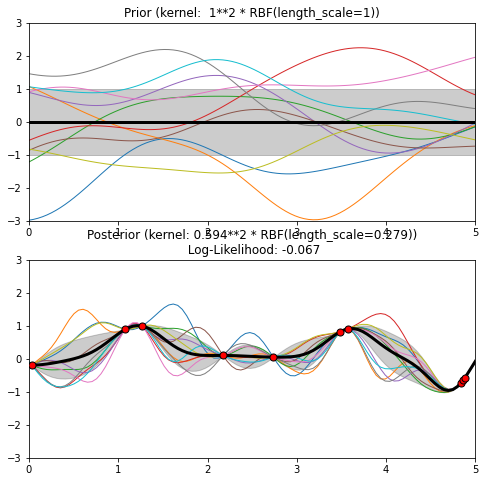

In [7]:
prior_and_posterior(
    kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
)

### Rational quadratic kernel
The RationalQuadratic kernel can be seen as a scale mixture (an infinite sum) of RBF kernels with different characteristic length-scales. It is parameterized by a length-scale parameter $l>0$and a scale mixture parameter $\alpha>0$. Only the isotropic variant where is a scalar is supported at the moment. The kernel is given by:
$$
k(x_i,x_j)=\left (1+\frac{\| x_i-x_j \|_2^2}{2\alpha l^2} \right )^{-\alpha}
$$
The prior and posterior of a GP resulting from a RationalQuadratic kernel are shown in the following figure:

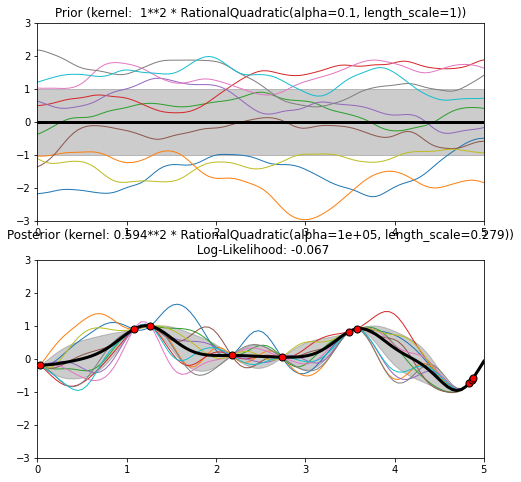

In [37]:
prior_and_posterior(
    kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1)
)

### Exp-Sine-Squared kernel

The ExpSineSquared kernel allows modeling periodic functions. It is parameterized by a length-scale parameter $l>0$ and a periodicity parameter $p>0$. Only the isotropic variant where $l$ is a scalar is supported at the moment. The kernel is given by:
$$
k(x_i,x_j)=\text{exp}\left ( \frac{2\text{sin}^2(\pi \| x_i-x_j \|_2/p)}{l^2} \right )
$$
The prior and posterior of a GP resulting from an ExpSineSquared kernel are shown in the following figure:

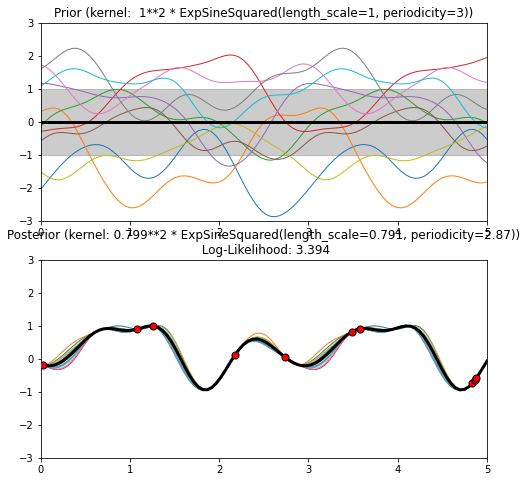

In [9]:
prior_and_posterior(
    kernel=1.0 * ExpSineSquared(
        length_scale=1.0,
        periodicity=3.0,
        length_scale_bounds=(0.1, 10.0),
        periodicity_bounds=(1.0, 10.0)
    )
)

### Matérn kernel

The Matern kernel is a stationary kernel and a generalization of the RBF kernel. It has an additional parameter $\nu$ which controls the smoothness of the resulting function. It is parameterized by a length-scale parameter $l>0$, which can either be a scalar (isotropic variant of the kernel) or a vector with the same number of dimensions as the inputs $x$ (anisotropic variant of the kernel). The kernel is given by:
$$
k(x_i,x_j)=\sigma^2\frac{2^{1-\nu}}{\Gamma(\nu)} \left ( \gamma\sqrt{2\nu}\frac{\|x_i-x_j\|}{l} \right)^\nu K_\nu \left ( \gamma\sqrt{2\nu}\frac{\|x_i-x_j\|}{l} \right )
$$
Where $\Gamma(\nu)$ is the gamma function and $K_\nu$ is the modified Bessel function of the second kind.
As $\nu\rightarrow\infty$, the Matérn kernel converges to the RBF kernel. When $\nu=1/2$, the Matérn kernel becomes identical to the absolute exponential kernel, i.e.,
$$
k(x_i,x_j)=\sigma^2\text{exp} \left ( -\gamma\frac{\|x_i-x_j\|}{l} \right ) \quad \nu=\frac{1}{2}
$$
In particular, $\nu=3/2$:
$$
k(x_i,x_j)=\sigma^2 \left ( 1+\gamma\sqrt{3}\frac{\|x_i-x_j\|}{l} \right ) \text{exp} \left ( -\gamma\sqrt{3}\frac{\|x_i-x_j\|}{l} \right ) \quad \nu=\frac{3}{2}
$$
and $\nu=5/2$:
$$
k(x_i,x_j)=\sigma^2 \left ( 1+\gamma\sqrt{5}\frac{\|x_i-x_j\|}{l}+\frac{5}{3}\gamma^2\frac{\|x_i-x_j\|^2}{l^2} \right ) \text{exp} \left ( -\gamma\sqrt{5}\frac{\|x_i-x_j\|}{l} \right ) \quad \nu=\frac{5}{2}
$$
are popular choices for learning functions that are not infinitely differentiable (as assumed by the RBF kernel) but at least once ($\nu=3/2$) or twice differentiable ($\nu=5/2$).

The flexibility of controlling the smoothness of the learned function via $\nu$ allows adapting to the properties of the true underlying functional relation. The prior and posterior of a GP resulting from a Matérn kernel are shown in the following figure:

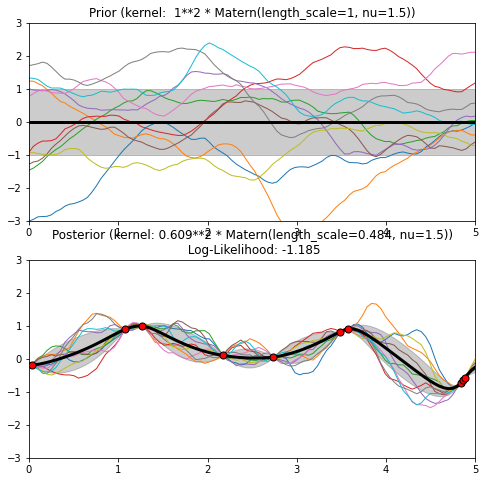

In [11]:
prior_and_posterior(
    kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
)

## Prediction using noise-free observation

In [12]:
def f(x):
    return x * np.sin(x)

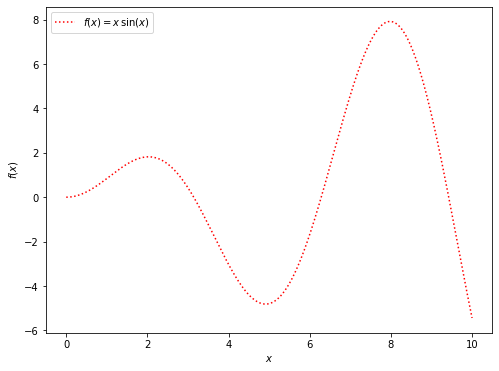

In [13]:
def figure1():
    Xstar = np.atleast_2d(np.linspace(0, 10, 1000)).T

    plotGP(Xstar=Xstar, f=f, flabel=r'$f(x) = x\,\sin(x)$')

figure1()

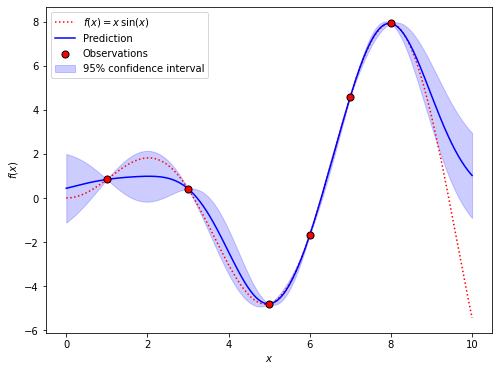

In [14]:
# kernel = C(1.0, (1e-3, 1e3)) * RBF(10.0, (1e-2, 1e2))

def figure2():
    X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

    # Observations
    y = f(X).ravel()

    Xstar = np.atleast_2d(np.linspace(0, 10, 1000)).T
    
    gp = GaussianProcessRegressor()
    gp.fit(X, y)
    mu, sigma = gp.predict(Xstar, return_std=True)
    plotGP(X=X, y=y, Xstar=Xstar, mu=mu, f=f, flabel=r'$f(x) = x\,\sin(x)$', sigma=sigma)

figure2()

## Prediction using noisy observation

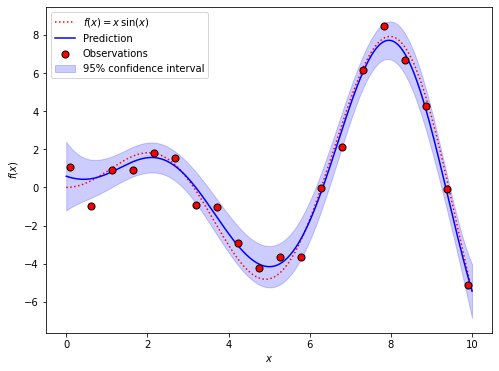

In [15]:
def figure3():
    X = np.atleast_2d(np.linspace(0.1, 9.9, 20)).T

    # Noisy observations
    np.random.seed(1)

    y = f(X).ravel()
    dy = 0.5 + 1.0 * np.random.random(y.shape)
    noise = np.random.normal(0, dy)
    y += noise
    
    Xstar = np.atleast_2d(np.linspace(0, 10, 1000)).T

    # Instantiate a Gaussian Process model

    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10.0, (1e-2, 1e2))

    gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                                  n_restarts_optimizer=10)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, y)

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    mu, sigma = gp.predict(Xstar, return_std=True)

    plotGP(X=X, y=y, Xstar=Xstar, mu=mu, f=f, flabel=r'$f(x) = x\,\sin(x)$', sigma=sigma)

figure3()

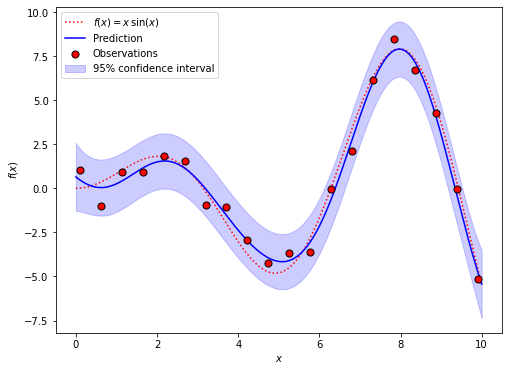

In [16]:
def figure4():
    X = np.atleast_2d(np.linspace(0.1, 9.9, 20)).T

    # Noisy observations
    np.random.seed(1)

    y = f(X).ravel()
    dy = 0.5 + 1.0 * np.random.random(y.shape)
    noise = np.random.normal(0, dy)
    y += noise
    
    Xstar = np.atleast_2d(np.linspace(0, 10, 1000)).T

    # Instantiate a Gaussian Process model

    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10.0, (1e-2, 1e2)) + WhiteKernel(noise_level=1e-2)

    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, y)

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    mu, sigma = gp.predict(Xstar, return_std=True)

    plotGP(X=X, y=y, Xstar=Xstar, mu=mu, f=f, flabel=r'$f(x) = x\,\sin(x)$', sigma=sigma)

figure4()